# Classification using Word2Vec

## Imports

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from datasets import load_dataset
from tabulate import tabulate

from tqdm.notebook import tqdm
from transformers import BertTokenizer

/home/simon/Documents/LLM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [2]:
dataset = load_dataset("scikit-learn/imdb", split="train")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)

Length of the vocabulary: 30522


In [3]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map: 100%|██████████| 5000/5000 [00:19<00:00, 262.25 examples/s]


In [4]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

data_collator = DataCollator(tokenizer)

In [5]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

## Model

In [7]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size: int, embeddings: nn.Embedding, feature_size: int = 100, kernel_size: int = 3):
        super().__init__()
        self.feature_size = feature_size
        self.embeddings = embeddings
        self.embedding_dim = self.embeddings.embedding_dim

        self.conv = nn.Conv1d(
            self.embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )

        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids: torch.Tensor):
        # In pytorch, convolution expects (B,d,L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)
        # Before the linear, do something with dims the dimension
        # Because Linear works on the final dim
        # (B,d,1) -> (B,d)
        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(path: str, *, freeze: bool = False):
  torch.serialization.add_safe_globals([nn.Embedding, set])
  embeddings = torch.load(path, map_location=device, weights_only=True)

  if freeze:
    embeddings.weight.requires_grad = False

  return Conv1dClassifier(
    vocab_size=VOCSIZE,
    embeddings=embeddings,
  )

def create_default_model(embedding_dim: int, *, freeze: bool = False):
  embeddings = nn.Embedding(VOCSIZE, embedding_dim)

  if freeze:
    embeddings.weight.requires_grad = False

  return Conv1dClassifier(
    vocab_size=VOCSIZE,
    embeddings=embeddings,
  )


model_default = create_default_model(25)
model_pretrained = load_model('model_dim-25_radius-10_ratio-5-batch-1200-epoch-10.ckpt')


# Test on random sentence

random_inputs = torch.randint(0, VOCSIZE, (4, 100))

with torch.no_grad():
  print(torch.stack([
    model_default(random_inputs),
    model_pretrained(random_inputs),
  ]).squeeze().T)

tensor([[0.8500, 0.1783],
        [0.9382, 0.2586],
        [0.8852, 0.1378],
        [0.8088, 0.2200]])


## Training

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model: nn.Module):
  loss_function = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  n_epochs = 10
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []

  model.to(device)


  def compute_accuracy(predictions, labels):
      pred = (predictions > 0.5).int()
      correct = (labels == pred).sum().item()
      return correct


  def train_one_epoch(model, dataloader, optimizer, loss_function):
      model.train()
      total_loss = 0
      correct = 0
      total_batches = len(dataloader)

      for batch in tqdm(dataloader, leave=True):
          batch = {k: v.to(device) for k, v in batch.items()}
          optimizer.zero_grad()
          probs = model(batch["review_ids"])
          gold = batch["label"]

          correct += compute_accuracy(probs, gold)
          loss = loss_function(probs, gold.float())
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

      avg_loss = total_loss / total_batches
      avg_accuracy = (correct * 100) / n_train  # Calculate accuracy in percentage
      return avg_loss, avg_accuracy


  def validate_one_epoch(model, dataloader, loss_function):
      model.eval()
      total_loss = 0
      correct = 0
      total_batches = len(dataloader)

      with torch.no_grad():
          for batch in tqdm(dataloader, leave=True):
              batch = {k: v.to(device) for k, v in batch.items()}
              probs = model(batch["review_ids"])
              gold = batch["label"]

              correct += compute_accuracy(probs, gold)
              loss = loss_function(probs, gold.float())
              total_loss += loss.item()

      avg_loss = total_loss / total_batches
      avg_accuracy = (correct * 100) / n_valid  # Calculate accuracy in percentage
      return avg_loss, avg_accuracy


  for epoch in range(n_epochs):
      train_avg_loss, train_avg_acc = train_one_epoch(
          model, train_dataloader, optimizer, loss_function
      )
      valid_avg_loss, valid_avg_acc = validate_one_epoch(
          model, valid_dataloader, loss_function
      )

      train_losses.append(train_avg_loss)
      valid_losses.append(valid_avg_loss)
      train_accs.append(train_avg_acc)
      valid_accs.append(valid_avg_acc)

      print(
          f"Epoch {epoch+1}/{n_epochs}",
          f"Train Loss: {train_avg_loss:.2f}",
          f"Train Acc: {train_avg_acc:.2f}%",
          f" | Valid Loss: {valid_avg_loss:.2f}",
          f"Valid Acc: {valid_avg_acc:.2f}%",
      )

  return valid_accs

  # # Plotting Loss and Accuracy Curves
  # epochs_range = range(1, n_epochs + 1)

  # plt.figure(figsize=(12, 5))

  # # Loss plot
  # plt.subplot(1, 2, 1)
  # plt.plot(epochs_range, train_losses, label="Train Loss")
  # plt.plot(epochs_range, valid_losses, label="Validation Loss")
  # plt.title("Loss Curves")
  # plt.xlabel("Epochs")
  # plt.ylabel("Loss")
  # plt.legend()

  # # Accuracy plot
  # plt.subplot(1, 2, 2)
  # plt.plot(epochs_range, train_accs, label="Train Accuracy")
  # plt.plot(epochs_range, valid_accs, label="Validation Accuracy")
  # plt.title("Accuracy Curves")
  # plt.xlabel("Epochs")
  # plt.ylabel("Accuracy (%)")
  # plt.legend()

  # plt.tight_layout()
  # plt.show()

# train_model(model_default)

  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 98.35it/s]


Epoch 1/10 Train Loss: 0.72 Train Acc: 53.27%  | Valid Loss: 0.66 Valid Acc: 61.60%


100%|██████████| 32/32 [00:00<00:00, 93.42it/s]


Epoch 2/10 Train Loss: 0.64 Train Acc: 62.88%  | Valid Loss: 0.60 Valid Acc: 70.40%


100%|██████████| 32/32 [00:00<00:00, 113.12it/s]


Epoch 3/10 Train Loss: 0.59 Train Acc: 68.45%  | Valid Loss: 0.57 Valid Acc: 72.90%


100%|██████████| 32/32 [00:00<00:00, 86.54it/s]


Epoch 4/10 Train Loss: 0.56 Train Acc: 70.97%  | Valid Loss: 0.55 Valid Acc: 75.20%


100%|██████████| 32/32 [00:00<00:00, 105.01it/s]


Epoch 5/10 Train Loss: 0.52 Train Acc: 74.12%  | Valid Loss: 0.52 Valid Acc: 76.80%


100%|██████████| 32/32 [00:00<00:00, 108.56it/s]


Epoch 6/10 Train Loss: 0.49 Train Acc: 76.95%  | Valid Loss: 0.50 Valid Acc: 78.00%


100%|██████████| 32/32 [00:00<00:00, 108.73it/s]


Epoch 7/10 Train Loss: 0.45 Train Acc: 79.83%  | Valid Loss: 0.48 Valid Acc: 78.20%


100%|██████████| 32/32 [00:00<00:00, 95.67it/s]


Epoch 8/10 Train Loss: 0.40 Train Acc: 81.80%  | Valid Loss: 0.47 Valid Acc: 78.30%


100%|██████████| 32/32 [00:00<00:00, 93.00it/s]


Epoch 9/10 Train Loss: 0.37 Train Acc: 82.83%  | Valid Loss: 0.45 Valid Acc: 79.20%


100%|██████████| 32/32 [00:00<00:00, 95.39it/s]


Epoch 10/10 Train Loss: 0.34 Train Acc: 84.62%  | Valid Loss: 0.44 Valid Acc: 80.00%


100%|██████████| 32/32 [00:00<00:00, 76.67it/s]


Epoch 1/10 Train Loss: 0.74 Train Acc: 51.20%  | Valid Loss: 0.66 Valid Acc: 61.70%


100%|██████████| 32/32 [00:00<00:00, 98.58it/s] 


Epoch 2/10 Train Loss: 0.65 Train Acc: 60.80%  | Valid Loss: 0.62 Valid Acc: 69.20%


100%|██████████| 32/32 [00:00<00:00, 112.05it/s]


Epoch 3/10 Train Loss: 0.61 Train Acc: 65.53%  | Valid Loss: 0.59 Valid Acc: 72.30%


100%|██████████| 32/32 [00:00<00:00, 107.59it/s]


Epoch 4/10 Train Loss: 0.59 Train Acc: 69.03%  | Valid Loss: 0.57 Valid Acc: 73.60%


100%|██████████| 32/32 [00:00<00:00, 111.45it/s]


Epoch 5/10 Train Loss: 0.57 Train Acc: 70.72%  | Valid Loss: 0.55 Valid Acc: 74.60%


100%|██████████| 32/32 [00:00<00:00, 110.49it/s]


Epoch 6/10 Train Loss: 0.54 Train Acc: 72.72%  | Valid Loss: 0.54 Valid Acc: 75.70%


100%|██████████| 32/32 [00:00<00:00, 85.93it/s]


Epoch 7/10 Train Loss: 0.52 Train Acc: 74.28%  | Valid Loss: 0.53 Valid Acc: 75.20%


100%|██████████| 32/32 [00:00<00:00, 109.81it/s]


Epoch 8/10 Train Loss: 0.51 Train Acc: 74.97%  | Valid Loss: 0.52 Valid Acc: 75.80%


100%|██████████| 32/32 [00:00<00:00, 106.93it/s]


Epoch 9/10 Train Loss: 0.49 Train Acc: 76.88%  | Valid Loss: 0.51 Valid Acc: 76.30%


100%|██████████| 32/32 [00:00<00:00, 110.23it/s]


Epoch 10/10 Train Loss: 0.48 Train Acc: 77.08%  | Valid Loss: 0.51 Valid Acc: 76.50%


100%|██████████| 32/32 [00:00<00:00, 104.36it/s]


Epoch 1/10 Train Loss: 0.70 Train Acc: 50.58%  | Valid Loss: 0.69 Valid Acc: 51.30%


100%|██████████| 32/32 [00:00<00:00, 110.13it/s]


Epoch 2/10 Train Loss: 0.67 Train Acc: 57.45%  | Valid Loss: 0.69 Valid Acc: 52.10%


100%|██████████| 32/32 [00:00<00:00, 110.86it/s]


Epoch 3/10 Train Loss: 0.64 Train Acc: 65.70%  | Valid Loss: 0.68 Valid Acc: 57.60%


100%|██████████| 32/32 [00:00<00:00, 116.72it/s]


Epoch 4/10 Train Loss: 0.58 Train Acc: 74.05%  | Valid Loss: 0.68 Valid Acc: 57.10%


100%|██████████| 32/32 [00:00<00:00, 116.11it/s]


Epoch 5/10 Train Loss: 0.50 Train Acc: 83.20%  | Valid Loss: 0.67 Valid Acc: 58.30%


100%|██████████| 32/32 [00:00<00:00, 110.37it/s]


Epoch 6/10 Train Loss: 0.39 Train Acc: 88.85%  | Valid Loss: 0.67 Valid Acc: 58.20%


100%|██████████| 32/32 [00:00<00:00, 112.97it/s]


Epoch 7/10 Train Loss: 0.28 Train Acc: 93.70%  | Valid Loss: 0.67 Valid Acc: 61.90%


100%|██████████| 32/32 [00:00<00:00, 116.77it/s]


Epoch 8/10 Train Loss: 0.19 Train Acc: 96.92%  | Valid Loss: 0.69 Valid Acc: 61.30%


100%|██████████| 32/32 [00:00<00:00, 114.17it/s]


Epoch 9/10 Train Loss: 0.13 Train Acc: 98.03%  | Valid Loss: 0.71 Valid Acc: 63.20%


100%|██████████| 32/32 [00:00<00:00, 117.88it/s]


Epoch 10/10 Train Loss: 0.10 Train Acc: 98.83%  | Valid Loss: 0.73 Valid Acc: 64.00%


100%|██████████| 32/32 [00:00<00:00, 94.99it/s] 


Epoch 1/10 Train Loss: 0.71 Train Acc: 51.02%  | Valid Loss: 0.70 Valid Acc: 51.10%


100%|██████████| 32/32 [00:00<00:00, 95.79it/s]


Epoch 2/10 Train Loss: 0.68 Train Acc: 55.95%  | Valid Loss: 0.70 Valid Acc: 51.30%


100%|██████████| 32/32 [00:00<00:00, 77.96it/s]


Epoch 3/10 Train Loss: 0.67 Train Acc: 59.55%  | Valid Loss: 0.69 Valid Acc: 51.90%


100%|██████████| 32/32 [00:00<00:00, 113.11it/s]


Epoch 4/10 Train Loss: 0.65 Train Acc: 64.42%  | Valid Loss: 0.68 Valid Acc: 57.10%


100%|██████████| 32/32 [00:00<00:00, 112.28it/s]


Epoch 5/10 Train Loss: 0.63 Train Acc: 67.03%  | Valid Loss: 0.68 Valid Acc: 56.10%


100%|██████████| 32/32 [00:00<00:00, 115.92it/s]


Epoch 6/10 Train Loss: 0.59 Train Acc: 71.50%  | Valid Loss: 0.68 Valid Acc: 56.80%


100%|██████████| 32/32 [00:00<00:00, 115.00it/s]


Epoch 7/10 Train Loss: 0.56 Train Acc: 74.17%  | Valid Loss: 0.68 Valid Acc: 56.50%


100%|██████████| 32/32 [00:00<00:00, 115.20it/s]


Epoch 8/10 Train Loss: 0.53 Train Acc: 78.42%  | Valid Loss: 0.69 Valid Acc: 55.40%


100%|██████████| 32/32 [00:00<00:00, 107.99it/s]


Epoch 9/10 Train Loss: 0.48 Train Acc: 81.20%  | Valid Loss: 0.69 Valid Acc: 55.90%


100%|██████████| 32/32 [00:00<00:00, 107.90it/s]


Epoch 10/10 Train Loss: 0.45 Train Acc: 83.53%  | Valid Loss: 0.69 Valid Acc: 56.70%


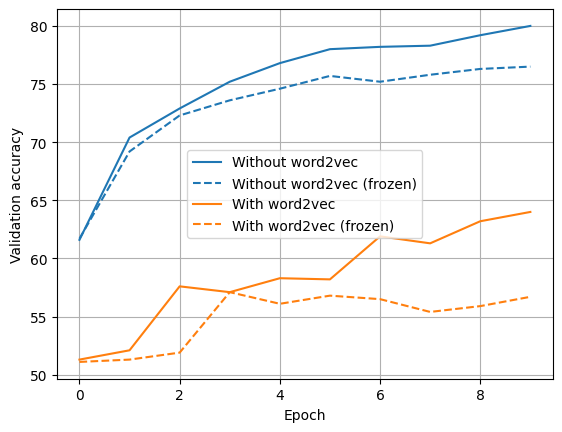

In [27]:
fig, ax = plt.subplots()

model_default = create_default_model(50)
model_random = __import__('copy').deepcopy(model_default)
model_random.embeddings.weight.requires_grad = False

for model, kwargs in zip(
  [
    model_default,
    model_random,
    load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt'),
    load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
  ],
  [
    dict(color='C0', linestyle='-', label='Without word2vec'),
    dict(color='C0', linestyle='--', label='Without word2vec (frozen)'),
    dict(color='C1', linestyle='-', label='With word2vec'),
    dict(color='C1', linestyle='--', label='With word2vec (frozen)'),
  ],
):
  val_accuracy = train_model(model)
  ax.plot(val_accuracy, **kwargs) # type: ignore

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation accuracy')
ax.grid()
ax.legend(loc='upper left');

100%|██████████| 32/32 [00:00<00:00, 180.45it/s]


Epoch 1/10 Train Loss: 0.71 Train Acc: 50.58%  | Valid Loss: 0.70 Valid Acc: 51.00%


100%|██████████| 32/32 [00:00<00:00, 181.20it/s]


Epoch 2/10 Train Loss: 0.68 Train Acc: 55.50%  | Valid Loss: 0.69 Valid Acc: 51.70%


100%|██████████| 32/32 [00:00<00:00, 175.71it/s]


Epoch 3/10 Train Loss: 0.67 Train Acc: 58.73%  | Valid Loss: 0.69 Valid Acc: 51.90%


100%|██████████| 32/32 [00:00<00:00, 180.28it/s]


Epoch 4/10 Train Loss: 0.65 Train Acc: 63.12%  | Valid Loss: 0.68 Valid Acc: 55.70%


100%|██████████| 32/32 [00:00<00:00, 179.74it/s]


Epoch 5/10 Train Loss: 0.63 Train Acc: 67.30%  | Valid Loss: 0.68 Valid Acc: 58.20%


100%|██████████| 32/32 [00:00<00:00, 178.90it/s]


Epoch 6/10 Train Loss: 0.60 Train Acc: 70.28%  | Valid Loss: 0.67 Valid Acc: 58.40%


100%|██████████| 32/32 [00:00<00:00, 171.91it/s]


Epoch 7/10 Train Loss: 0.56 Train Acc: 74.70%  | Valid Loss: 0.67 Valid Acc: 58.80%


100%|██████████| 32/32 [00:00<00:00, 175.19it/s]


Epoch 8/10 Train Loss: 0.53 Train Acc: 77.00%  | Valid Loss: 0.67 Valid Acc: 58.80%


100%|██████████| 32/32 [00:00<00:00, 134.84it/s]


Epoch 9/10 Train Loss: 0.49 Train Acc: 79.90%  | Valid Loss: 0.67 Valid Acc: 58.20%


100%|██████████| 32/32 [00:00<00:00, 179.46it/s]


Epoch 10/10 Train Loss: 0.45 Train Acc: 82.72%  | Valid Loss: 0.67 Valid Acc: 58.20%


100%|██████████| 32/32 [00:00<00:00, 163.39it/s]


Epoch 1/10 Train Loss: 0.71 Train Acc: 50.98%  | Valid Loss: 0.69 Valid Acc: 55.00%


100%|██████████| 32/32 [00:00<00:00, 154.97it/s]


Epoch 2/10 Train Loss: 0.66 Train Acc: 60.40%  | Valid Loss: 0.68 Valid Acc: 61.80%


100%|██████████| 32/32 [00:00<00:00, 157.28it/s]


Epoch 3/10 Train Loss: 0.61 Train Acc: 69.33%  | Valid Loss: 0.67 Valid Acc: 57.80%


100%|██████████| 32/32 [00:00<00:00, 130.91it/s]


Epoch 4/10 Train Loss: 0.55 Train Acc: 77.10%  | Valid Loss: 0.66 Valid Acc: 57.20%


100%|██████████| 32/32 [00:00<00:00, 146.91it/s]


Epoch 5/10 Train Loss: 0.48 Train Acc: 83.10%  | Valid Loss: 0.64 Valid Acc: 61.80%


100%|██████████| 32/32 [00:00<00:00, 154.93it/s]


Epoch 6/10 Train Loss: 0.40 Train Acc: 88.08%  | Valid Loss: 0.64 Valid Acc: 60.90%


100%|██████████| 32/32 [00:00<00:00, 156.63it/s]


Epoch 7/10 Train Loss: 0.33 Train Acc: 90.88%  | Valid Loss: 0.65 Valid Acc: 60.60%


100%|██████████| 32/32 [00:00<00:00, 157.15it/s]


Epoch 8/10 Train Loss: 0.27 Train Acc: 93.33%  | Valid Loss: 0.68 Valid Acc: 58.20%


100%|██████████| 32/32 [00:00<00:00, 157.11it/s]


Epoch 9/10 Train Loss: 0.24 Train Acc: 94.05%  | Valid Loss: 0.66 Valid Acc: 60.70%


100%|██████████| 32/32 [00:00<00:00, 158.26it/s]

Epoch 10/10 Train Loss: 0.19 Train Acc: 95.85%  | Valid Loss: 0.64 Valid Acc: 64.80%


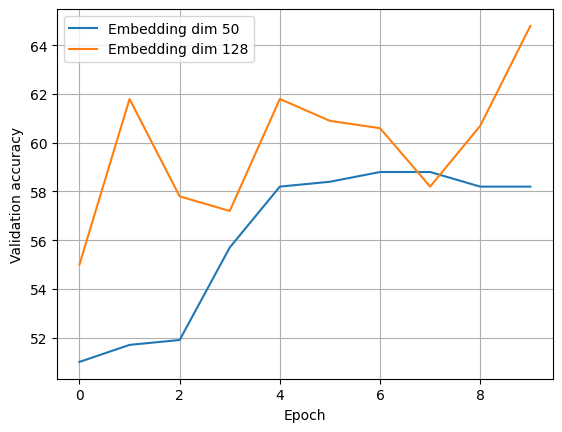

In [33]:
fig, ax = plt.subplots()

for model, kwargs in zip(
  [
    load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
    load_model('model_dim-128_radius-3_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
  ],
  [
    dict(color='C0', linestyle='-', label='Embedding dim 50'),
    dict(color='C1', linestyle='-', label='Embedding dim 128'),
  ],
):
  val_accuracy = train_model(model)
  ax.plot(val_accuracy, **kwargs) # type: ignore

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation accuracy')
ax.grid()
ax.legend();

In [ ]:
# fig, ax = plt.subplots()

models = [
  load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
  load_model('model_dim-50_radius-3_ratio-10-batch-1200-epoch-10.ckpt', freeze=True),
  load_model('model_dim-50_radius-6_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
  load_model('model_dim-50_radius-6_ratio-10-batch-1200-epoch-10.ckpt', freeze=True),
]

replicate_count = 5
results = torch.empty((len(models), replicate_count))

for replicate_index in range(replicate_count):
  for model_index, model in enumerate(models):
    results[model_index, replicate_index] = train_model(model)[-1]

# print(tabulate(results, tablefmt='fancy_grid'))

# for model, kwargs in zip(
#   [
#     load_model('model_dim-50_radius-3_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
#     load_model('model_dim-50_radius-3_ratio-10-batch-1200-epoch-10.ckpt', freeze=True),
#     load_model('model_dim-50_radius-6_ratio-5-batch-1200-epoch-10.ckpt', freeze=True),
#     load_model('model_dim-50_radius-6_ratio-10-batch-1200-epoch-10.ckpt', freeze=True),
#   ],
#   [
#     dict(color='C0', linestyle='-', label='R = 3, K = 5'),
#     dict(color='C1', linestyle='-', label='R = 3, K = 10'),
#     dict(color='C2', linestyle='-', label='R = 6, K = 5'),
#     dict(color='C3', linestyle='-', label='R = 6, K = 10'),
#   ],
# ):
#   val_accuracy = train_model(model)
#   ax.plot(val_accuracy, **kwargs) # type: ignore

# ax.set_xlabel('Epoch')
# ax.set_ylabel('Validation accuracy')
# ax.grid()
# ax.legend();

In [41]:
results.mean(dim=1)

tensor([56.6600, 62.4600, 58.3600, 57.8400])

In [35]:
fig.savefig('comparison2.png')